<a href="https://colab.research.google.com/github/alihamraoui/Redefining_Cancer/blob/master/visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
import matplotlib.pyplot as plt
import re
import time
import warnings
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from imblearn.over_sampling import SMOTE # Calibration des echantillons (a faire)
from scipy.sparse import hstack
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV # Calibration des echantillons (a faire)
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
import nltk
import math
import numpy as np 
import pandas as pd 
import pickle

In [232]:
!kaggle --version
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!cd input_data/
!kaggle competitions download -c msk-redefining-cancer-treatment

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
cp: cannot stat 'kaggle.json': No such file or directory
/bin/bash: line 0: cd: input_data/: No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Cou

## Load cleaned text (PICKLE object)

In [233]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive"
infile = open(DATA_PATH+"/clean_text.pkl",'rb')
df_merge = pickle.load(infile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
df_merge.head()

,id,gene,variation,class,text
0,0,FAM58A,Truncating Mutations,1,cyclindependent kinase cdks regulate variety f...
1,1,CBL,W802*,2,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas blineage ...


## Split Dataset : train and test

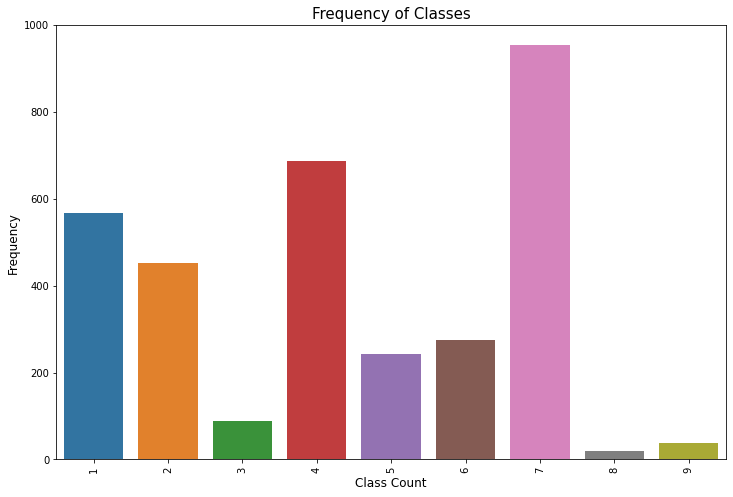

In [236]:
plt.figure(figsize=(12,8))
sns.countplot(x="class", data=df_merge)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

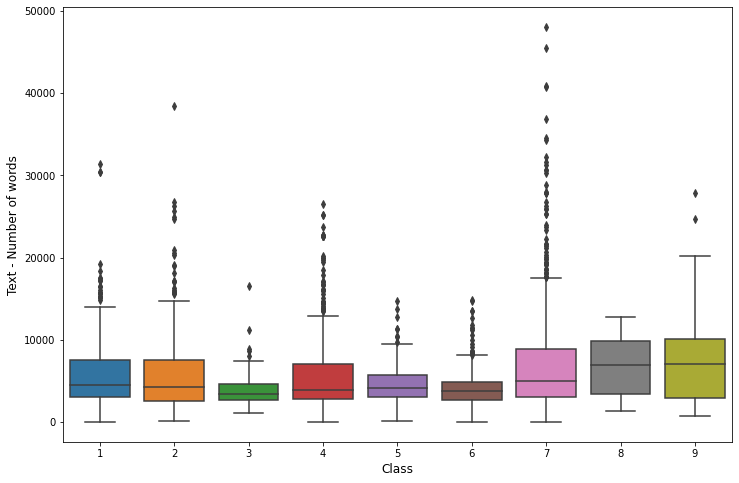

In [237]:
df_merge["Text_num_words"] = df_merge["text"].apply(lambda x: len(str(x).split()) )
#df_merge["Text_num_chars"] = df_merge["Text"].apply(lambda x: len(str(x)) )


#train_df = pd.merge(train_variants_df, train_text_df, on='id')
plt.figure(figsize=(12,8))
sns.boxplot(x='class', y='Text_num_words', data=df_merge)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

## TF-IDF :  term frequency–inverse document frequency
to reflect how important a word is to a document 

- transform words to numeric :  each word in text vocabulary is represented by a numeric number. text -> vector of numerics
- text Vectorisation : convert text to matrix by counting the occurrence of each word in a text.

In [238]:
from time import time
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [239]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# vectorizer instantiation
vocabulary_length = 6000
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english', max_features=vocabulary_length, use_idf=True)

# convertir text to matrix
tfidf_wm = tfidfvectorizer.fit_transform(df_merge.text).astype('float64')

In [240]:
df_countvect = pd.DataFrame(data = tfidf_wm.toarray(),index = df_merge.id, columns = tfidfvectorizer.get_feature_names())
#pd.merge(df_countvect,df_merge, on="ID",how="left")
df_countvect

,a_yinsfqea,aa,aac,aacr,aag,ab,abbreviation,abc,abcam,abd,abdominal,aberrant,aberrantly,aberration,abi,ability,abl,ablation,able,abnormal,abnormality,abolish,abolished,abolishes,abrogate,abrogated,abrogates,abrogation,absence,absent,absolute,absorbance,abstract,abundance,abundant,ac,acc,accelerate,accelerated,accepted,...,younger,yr,yu,yx,yy,zbp,zd,zebrafish,zeiss,zero,zhang,zinc,zn,znf,znþ,znþbinding,zone,µg,µgml,µl,µm,αc,αchelix,αhelices,αhelix,αketoglutarate,αtubulin,βactin,βcatenin,βgalactosidase,βsheet,βtrcp,γphosphate,γsecretase,δbraf,μg,μgml,μl,μm,μmoll
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.0,0.0,0.0,0.004451,0.000000,0.0,0.006537,0.0,0.0,0.007655,0.000000,0.0,0.000000,0.002580,0.0,0.0,0.000000,0.000000,0.008257,0.000000,0.000000,0.006697,0.0,0.000000,0.0,0.000000,0.007647,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.004603,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008611,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.010492,0.0,0.0,0.0,0.015371,0.000000,0.021731,0.022189,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.006627,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.004337,0.000000,0.000000,0.0,0.0,0.003163,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018507,0.032887,0.009308,0.012986,0.0,0.0,0.0,0.000000,0.0,0.0,0.004003,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.006627,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.004337,0.000000,0.000000,0.0,0.0,0.003163,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018507,0.032887,0.009308,0.012986,0.0,0.0,0.0,0.000000,0.0,0.0,0.004003,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.005577,0.0,0.006245,0.0,0.0,0.007313,0.000000,0.0,0.004854,0.002465,0.0,0.0,0.005715,0.000000,0.047332,0.000000,0.004832,0.000000,0.0,0.004868,0.0,0.019062,0.009741,0.016969,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.006263,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.005998,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.007342,0.000000,0.004152,0.000000,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.003795,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.005755,0.0,0.000000,0.004400,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.012936,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.003924,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.005352,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.006552,0.003582,0.000000,0.003153,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,0.0,0.002329,0.0,0.0,0.0,0.004270,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.002437,0.013614,0.0,0.0,0.004304,0.006414,0.007921,0.000000,0.000000,0.000000,0.0,0.002444,0.0,0.000000,0.001223,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.002437,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.002781,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0

In [241]:
n_samples = 2000
vocabulary_length = 6000
n_components = 9
n_top_words = 20

In [242]:
tf_vectorizer = CountVectorizer(analyzer='word',stop_words= 'english',max_features=vocabulary_length)
tf = tf_vectorizer.fit_transform(df_merge.text)

nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf_wm)

tfidf_feature_names = tfidfvectorizer.get_feature_names()

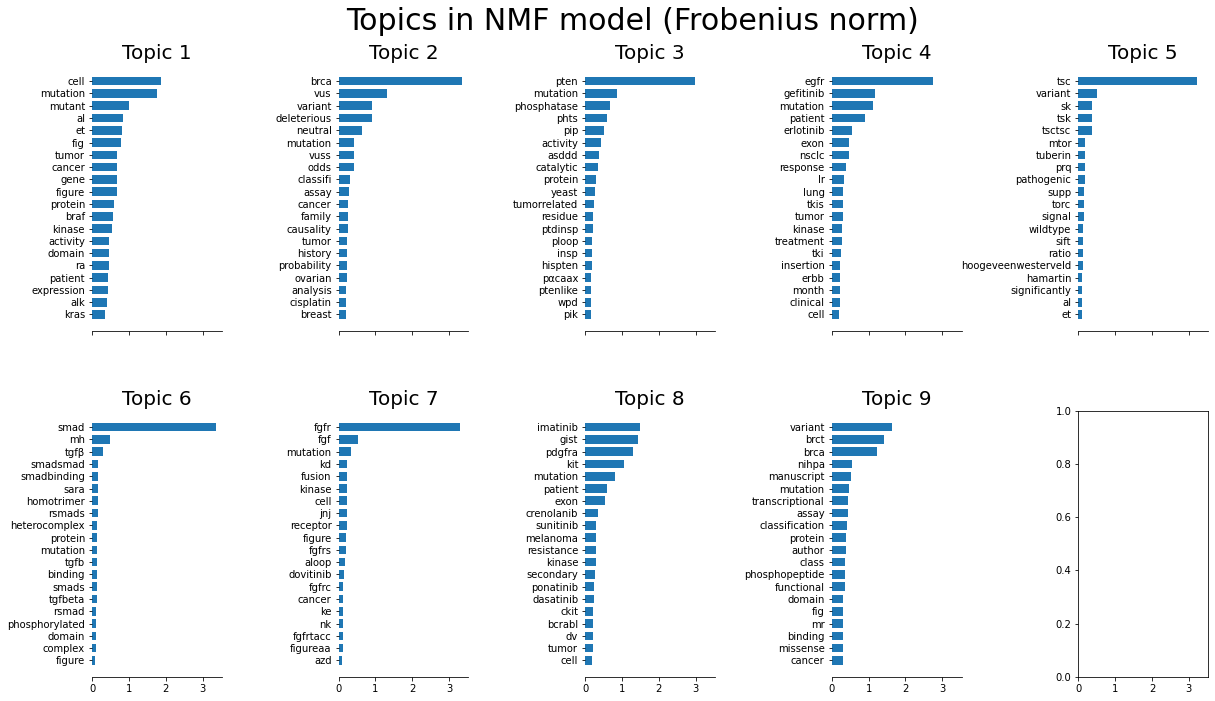

In [243]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(  nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")  

In [244]:
class_text = [''] * 9
for idx, classe in enumerate(df_merge['class']):
    class_text[classe-1] += df_merge['text'][idx]

In [245]:
text = [''] 
for idx in range(len(df_merge['text'])):
  text += df_merge['text'][idx]

In [246]:
most_word = dict(Counter(strin.split()).most_common(20))
most_word

{'al': 2032,
 'analysis': 1239,
 'cell': 5964,
 'et': 2034,
 'expression': 1685,
 'ezh': 1298,
 'fig': 1379,
 'figure': 2404,
 'gene': 2559,
 'idh': 4073,
 'level': 1314,
 'mutant': 3089,
 'mutation': 4739,
 'patient': 1313,
 'protein': 1262,
 'sample': 1297,
 'sfb': 2444,
 'splicing': 2137,
 'uaf': 1761,
 'using': 1517}

In [247]:
from collections import Counter
collect=[]
for strin in class_text:
  collect.append(dict(Counter(strin.split()).most_common(5)))
collect[0]

{'cell': 45829, 'gene': 21934, 'mutation': 50546, 'p': 29643, 'protein': 24999}

In [248]:
collect[idx].keys()

IndexError: ignored

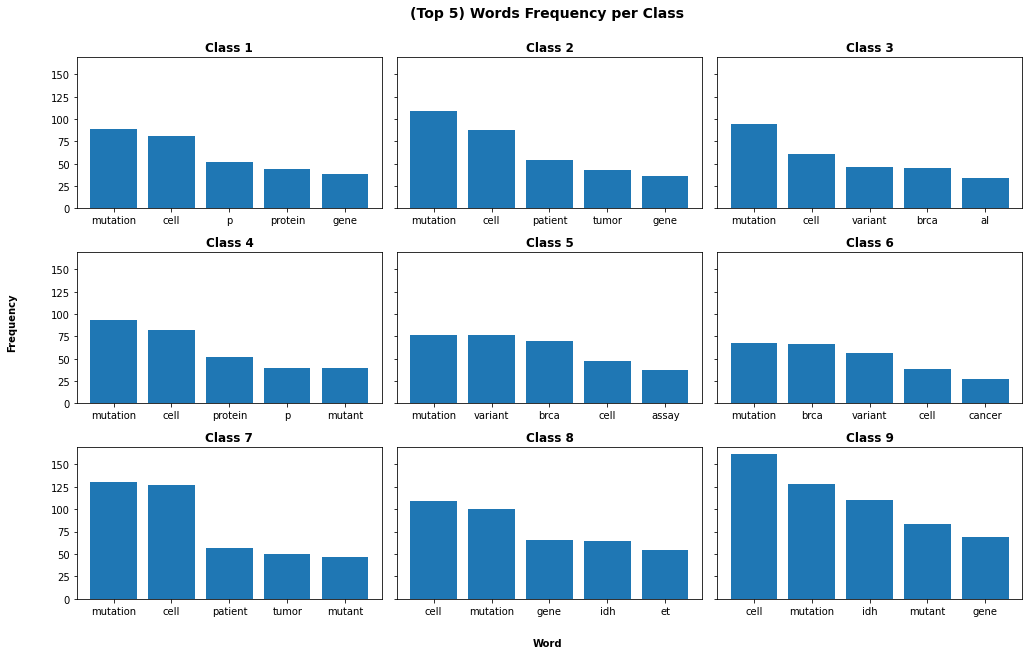

In [249]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(15,9))
class_i = [568, 452, 89, 686, 242, 275, 953, 19, 37]
for idx in range(9):
    labels = list(collect[idx].keys())
    val  = [ x/class_i[idx] for x in collect[idx].values()]
    ax = axes.flat[idx]
    ax.bar(labels, val,
           tick_label=labels) 
    ax.set_title("Class {}".format(idx+1),fontweight='bold')
    
fig.text(0.5, 0.97, '(Top 5) Words Frequency per Class', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Word', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
plt.savefig('class_words.png')

In [250]:
import gc
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# gc.collect()
# tfIdfMatrix = tfidf_wm.todense()
# labels = df_merge['class'].tolist()
# tsne_results = TSNE(n_components=2,init='random',random_state=0).fit_transform(tfIdfMatrix)
# plt.figure(figsize=(20,10))
# palette = sns.hls_palette(9, l=.3, s=.9)
# sns.scatterplot(
#     x=tsne_results[:,0], y=tsne_results[:,1],
#     hue=labels,
#     palette= palette,
#     legend="full",
#     alpha=0.3
# )
# plt.show()

In [251]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfidf_wm.toarray())
labels = df_merge['class'].tolist()
category_list = df_merge['class'].unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)  

In [252]:
df_pca = pd.DataFrame(data = tfIdfMat_reduced,index = df_merge.id)
X_train, X_test, y_train, y_test = train_test_split(df_pca, labels, stratify=labels,random_state=1)
X_train[0]

id
2445    0.676099
2919   -0.077197
261    -0.176109
1837   -0.055046
860    -0.106333
          ...   
704    -0.124922
1290   -0.061125
3206   -0.070809
209    -0.024590
2948   -0.084374
Name: 0, Length: 2490, dtype: float64

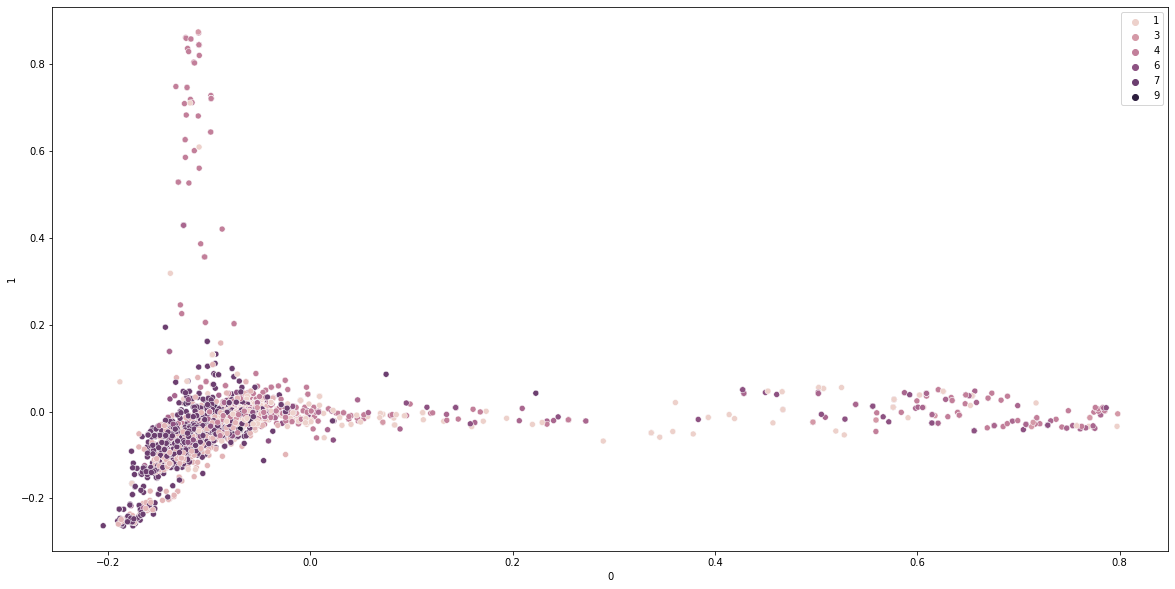

In [253]:
plt.figure(figsize=(20,10))
labels = df_merge['class'].tolist()
sns.scatterplot(x = df_pca [:][0], y= df_pca [:][1],
    hue=labels,
    legend="auto"
)

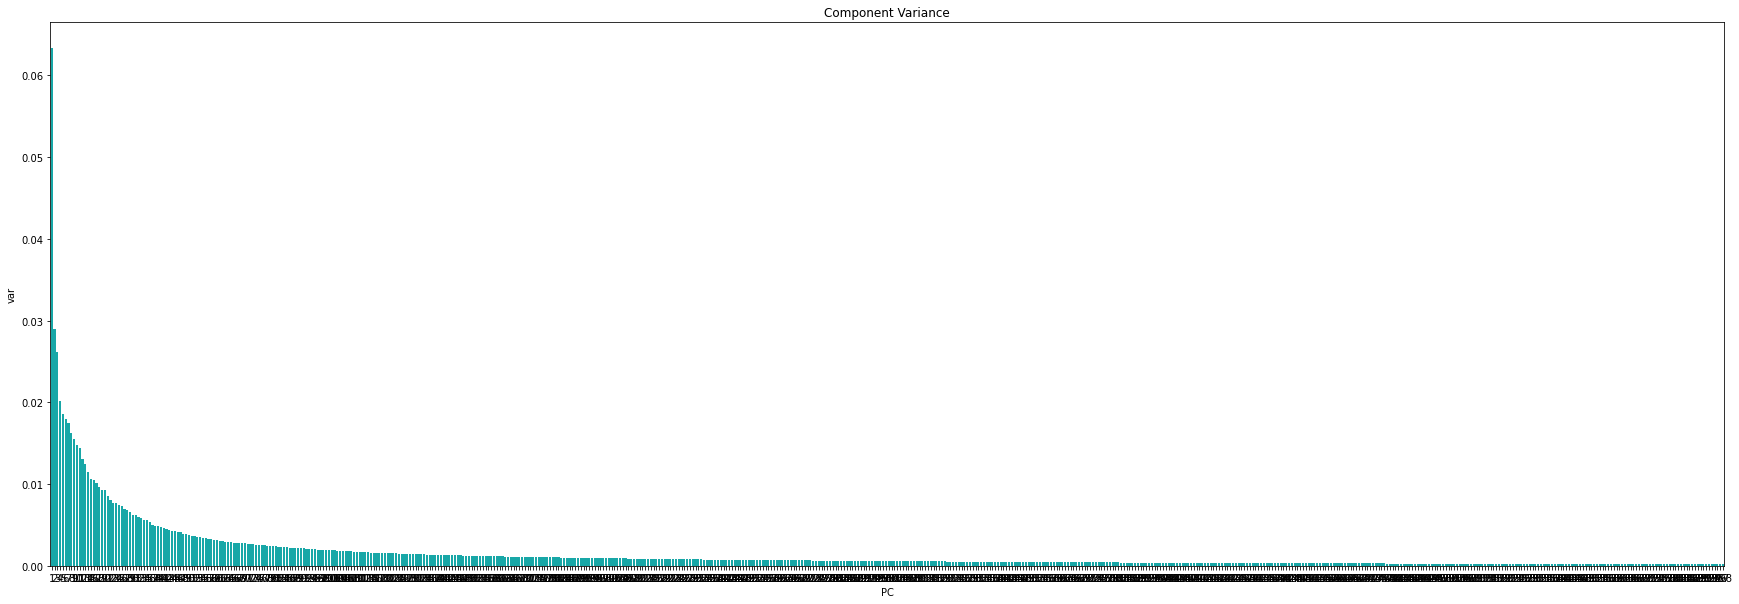

In [254]:
fig = plt.figure(figsize=(30,10))
dfScree = pd.DataFrame({'var':pca.explained_variance_ratio_,'PC': np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)})
sns.barplot(x='PC',y="var",data=dfScree, color="c").set_title('Component Variance');

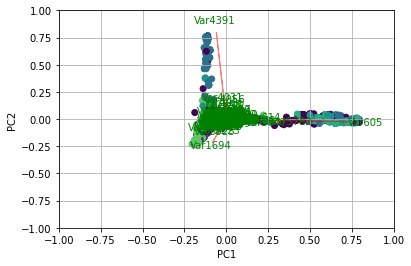

In [255]:
y = df_merge['class'].tolist()
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(tfIdfMat_reduced[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

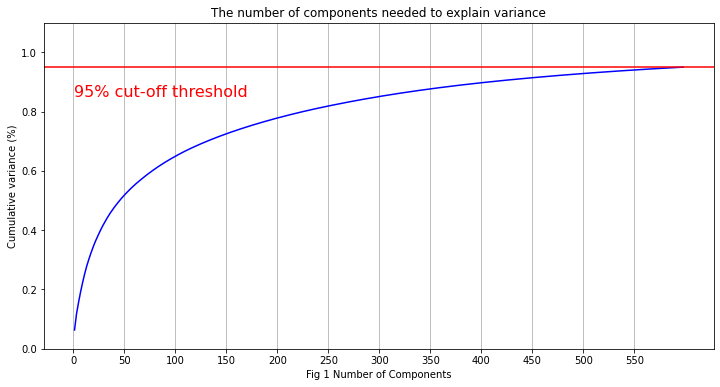

In [257]:
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1,len(pca.explained_variance_ratio_)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, linestyle='-', color='b')
plt.xlabel('Fig 1 Number of Components')
plt.xticks(np.arange(0, len(pca.explained_variance_ratio_), step=50)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')
plt.show()

In [258]:
# print Vocabulary
tfidf_tokens = tfidfvectorizer.get_feature_names()

## CNN : convolutional neural network


In [259]:
from tensorflow.keras.layers import SpatialDropout1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.layers import Input, Dense, Conv1D, Add
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [260]:
# y_test = test_y.to_numpy()
y_train2 = [x-1 for x in y_train]
y_test2 = [x-1 for x in y_test]
# Categorical
y_train_cat = to_categorical(y_train2, num_classes=9, dtype ="uint8")
y_test_cat = to_categorical(y_test2, num_classes=9, dtype ="uint8")

# Model

In [261]:
input = Input(shape=(X_train.shape[1], 1)) 
x = SpatialDropout1D(0.15)(input)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = layers.MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
out = Dense(9, activation='softmax')(x)
model = Model(input, out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trainning

In [262]:
history = model.fit(X_train, y_train_cat, batch_size=140, epochs=20, verbose=0, validation_split=0.2,  callbacks = EarlyStopping( monitor = "val_loss" ,patience=10))  # starts trainin

<function matplotlib.pyplot.show>

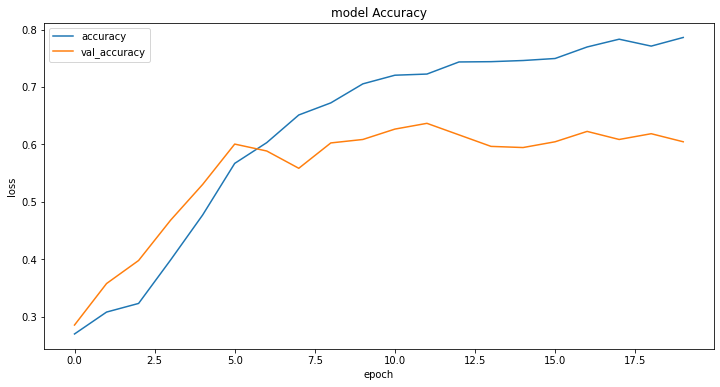

In [263]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'],loc = 'upper left')
plt.show

In [264]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import files
# predictions
predictions = model.predict(X_test)
y_pred = np.array([[False]*9]*len(predictions))
for i, elem in enumerate(predictions.argmax(axis=1)):
  y_pred[i][elem] = True
matrix = np.around(confusion_matrix(y_test_cat.argmax(axis=1), predictions.argmax(axis=1), normalize='pred'),2)

In [265]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test_cat, y_pred)

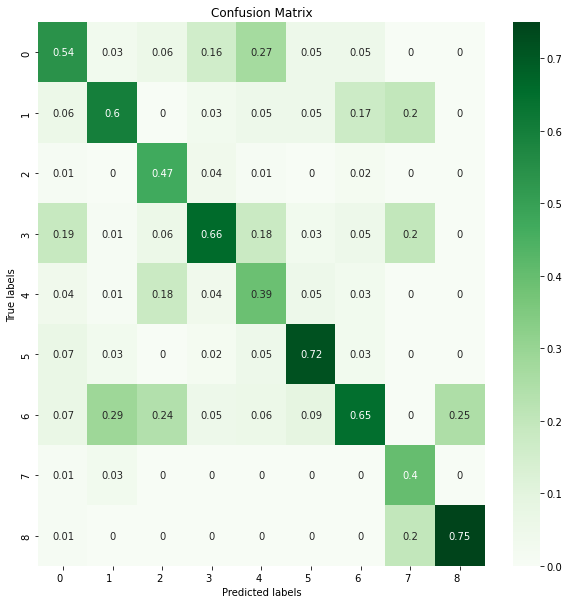

In [266]:
fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(matrix, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
plt.setp(ax.get_yticklabels(), horizontalalignment='right')
plt.setp(ax.get_xticklabels(), horizontalalignment='right')     
plt.show()

#SMOTE OVERSAMPLING

In [267]:
smote_over_sample = SMOTE(sampling_strategy='not majority')
labels = df_merge['class'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X, y, stratify=y,random_state=1)   

[]

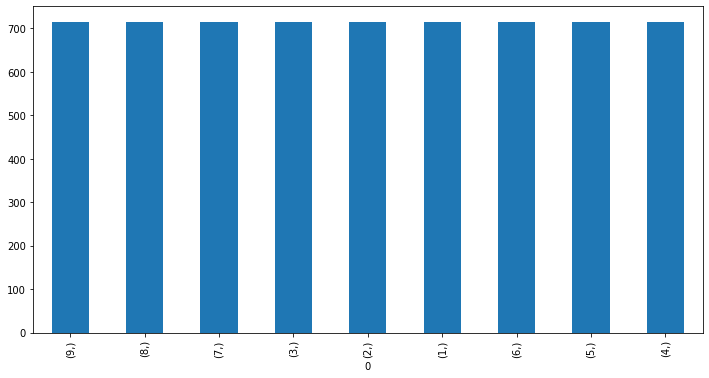

In [268]:
(pd.DataFrame(y_train_res).value_counts(sort=True)).plot(kind='bar')
plt.plot()

[]

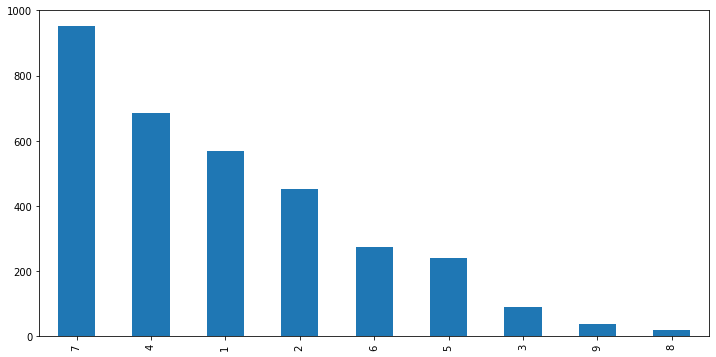

In [269]:
(df_merge['class'].value_counts(sort=True)).plot(kind='bar')
plt.plot()

In [270]:
y_train2_res = [x-1 for x in y_train_res]
y_test2_res = [x-1 for x in y_test_res]
# Categorical
y_train_res_cat = to_categorical(y_train2_res, num_classes=9, dtype ="uint8")
y_test_res_cat = to_categorical(y_test2_res, num_classes=9, dtype ="uint8")

In [271]:
input = Input(shape=(X_train.shape[1], 1)) 
x = SpatialDropout1D(0.1)(input)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
#x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)

x = Flatten()(x)
out = Dense(9, activation='softmax')(x)
print(x.shape)
model = Model(input, out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

(None, 74496)


In [272]:
history = model.fit(X_train_res, y_train_res_cat, batch_size=180, epochs=40, verbose=0, validation_split = 0.1,  callbacks = EarlyStopping( monitor = "val_loss",patience=10))  # starts trainin

<function matplotlib.pyplot.show>

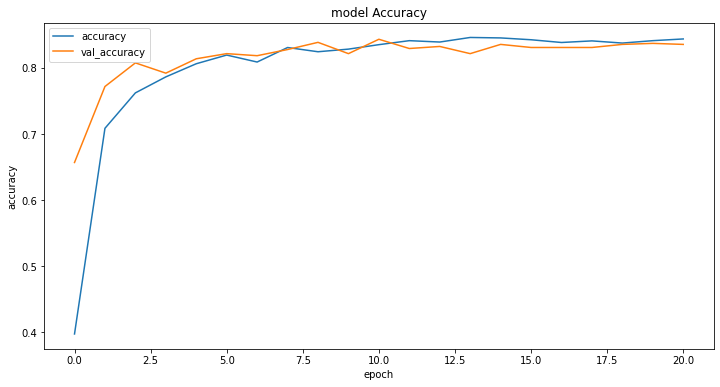

In [273]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'],loc = 'upper left')
plt.show

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss','val_loss'],loc = 'upper left')
plt.show

In [274]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import files
# predictions
predictions = model.predict(X_test)
y_pred = np.array([[False]*9]*len(predictions))
for i, elem in enumerate(predictions.argmax(axis=1)):
  y_pred[i][elem] = True
matrix = np.around(confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1), normalize='true'),2)

## Predictions Analysis

In [275]:
vec_pred = y_pred.argmax(axis=1) == y_test_cat.argmax(axis=1)
vec_test = list(X_test.index.values)
data_pred = pd.DataFrame({'pred': vec_pred, 'id': vec_test})

In [276]:
dd_analysis_test = pd.merge(data_pred,df_merge, on= 'id')
dd_analysis_test.head()

,pred,id,gene,variation,class,text,Text_num_words
0,True,418,TP53,R110L,1,many p missense mutation posse dominantnegativ...,8038
1,True,2452,BRCA1,C39Y,4,published analysis effect missense mutation br...,13508
2,True,2530,BRCA1,G1738R,4,abstract brca gene individual risk breast ovar...,7582
3,False,1593,VHL,V84L,6,von hippellindau tumor suppressor protein pvhl...,4346
4,True,1198,PIK3CA,Amplification,2,ovarian cancer fifthleading cause cancer death...,38425


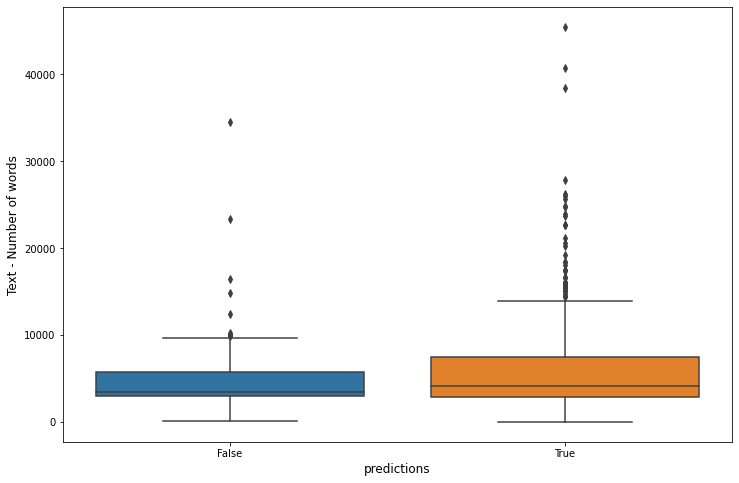

In [277]:
plt.figure(figsize=(12,8))
sns.boxplot(x='pred', y='Text_num_words', data=dd_analysis_test)
plt.xlabel('predictions', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

In [281]:
True_liste = dd_analysis_test[dd_analysis_test['pred'] == True]
False_liste = dd_analysis_test[dd_analysis_test['pred'] == False]

In [279]:
from scipy import stats
stats.ttest_ind(True_liste['Text_num_words'], False_liste['Text_num_words'])

Ttest_indResult(statistic=2.39143597218221, pvalue=0.01700463585777568)

In [282]:
pp=[]
text = ' '.join(True_liste['text'])
counter_t = dict(Counter(text.split()).most_common(15))
pp.append(counter_t)
text = ' '.join(False_liste['text'])
counter_f = dict(Counter(text.split()).most_common(15))
pp.append(counter_f)

In [287]:
f_counter = Counter(counter_f)

t_counter = Counter(counter_t)

tot_dic = f_counter + t_counter

tot = dict(tot_dic)

percent_pred = {k: v / total for k, v in a.iteritems()}

{'activity': 3704,
 'al': 23965,
 'assay': 3752,
 'brca': 3920,
 'cancer': 28345,
 'cell': 72541,
 'domain': 20897,
 'et': 23918,
 'fig': 26147,
 'figure': 25870,
 'gene': 25162,
 'mutant': 27731,
 'mutation': 82897,
 'p': 20054,
 'patient': 23573,
 'protein': 30820,
 'tumor': 25828,
 'variant': 25388}

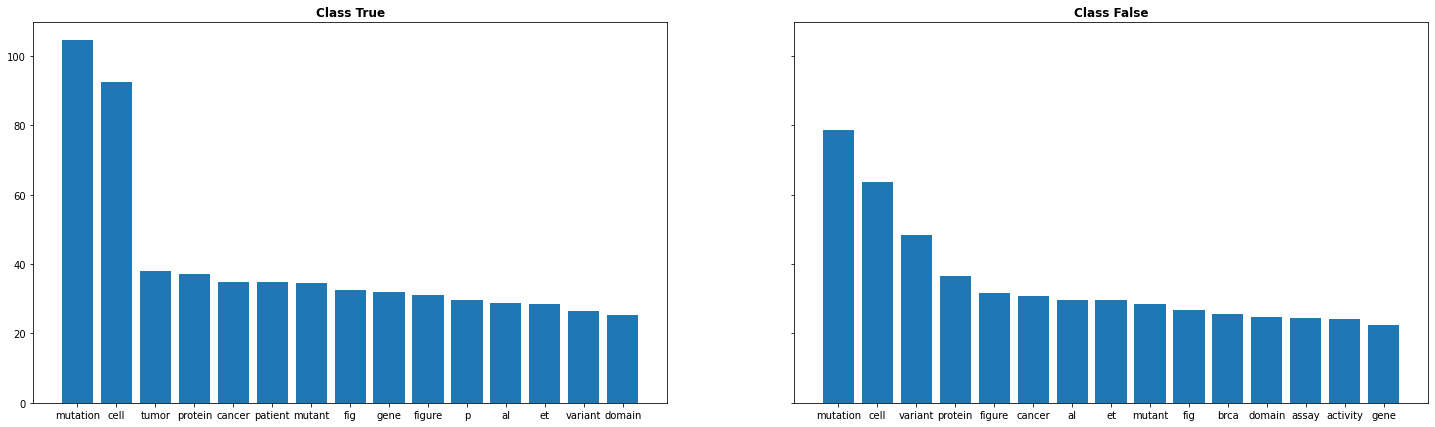

In [290]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25,7))
tf = ['True', 'False']
summ = [len(True_liste['Text_num_words']), len(False_liste['Text_num_words'])]
for idx in range(2):
    labels = list(pp[idx].keys())
    val  =  [x/summ[idx] for x in list(pp[idx].values())]
    ax = axes.flat[idx]
    ax.bar(labels, val,
           tick_label=labels) 
    ax.set_title("Class {}".format(tf[idx]),fontweight='bold')
    
# fig.text(0.5, 0.97, '(Top 5) Words Frequency per Class', ha='center', fontsize=14, fontweight='bold')
# fig.text(0.5, 0, 'Word', ha='center', fontweight='bold')
# fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
# fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

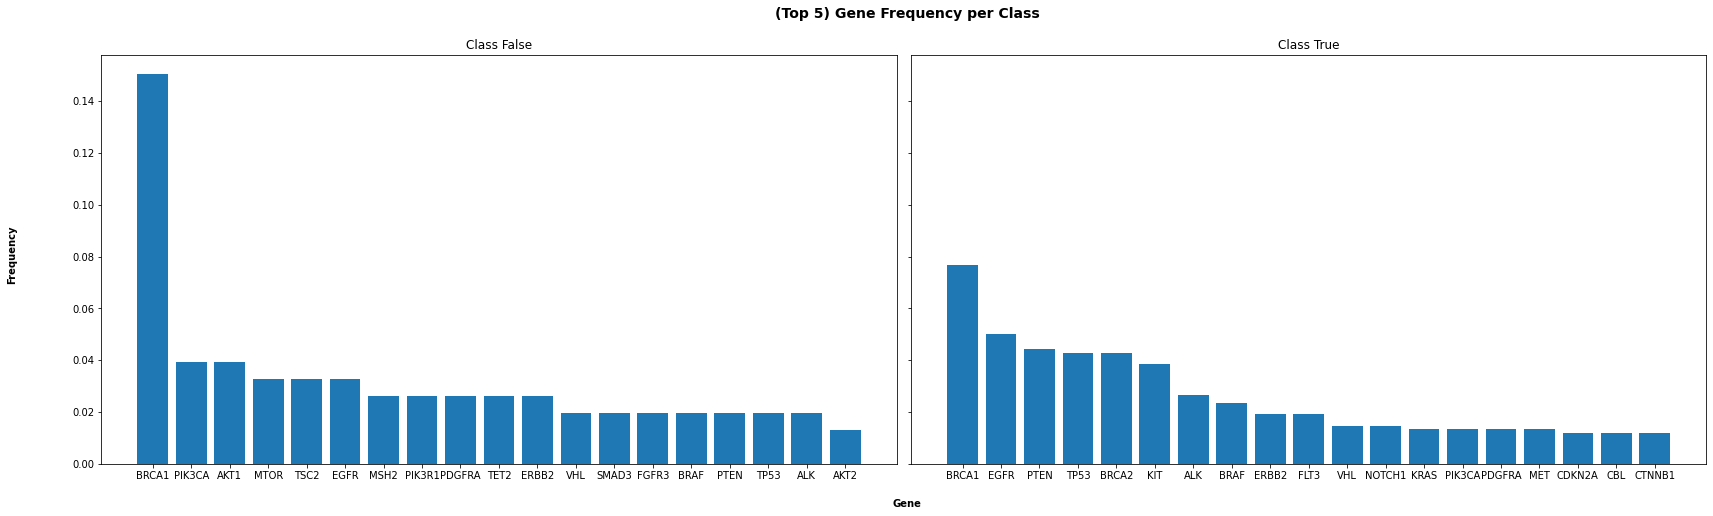

In [305]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25,7))

# Normalize value counts for better comparison
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

for idx, g in enumerate(dd_analysis_test.groupby('pred')):
    label, val = normalize_group(g[1]["gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(19), val[:19],
           tick_label=label[:19]) 
    ax.set_title("Class {}".format(g[0]))
    
fig.text(0.5, 0.97, '(Top 5) Gene Frequency per Class', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

In [337]:
x =dd_analysis_test.groupby('pred')["gene"].value_counts()
f_gene_counter = dict(x[0])
t_gene_counter = dict(x[1])
len(f_gene_counter)
tot_dic = {k: f_gene_counter.get(k, 0) + t_gene_counter.get(k, 0) for k in set(f_gene_counter) | set(t_gene_counter)}
len(tot_dic)

percent = {k: float(t_gene_counter[k])/tot_dic[k] for k in t_gene_counter}

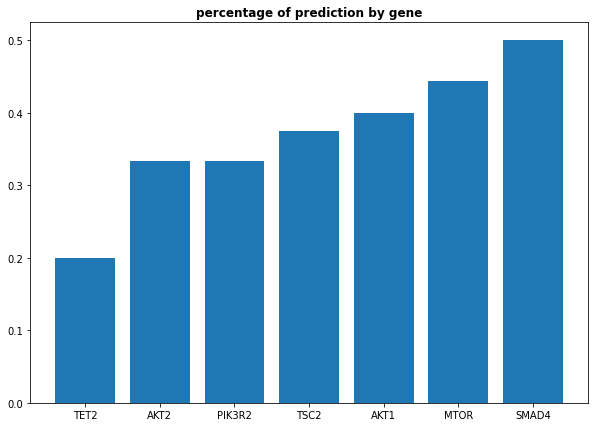

In [365]:
fig, axes = plt.subplots(figsize=(10,7))
sorted_x = sorted(percent.items(), key=lambda kv: kv[1])
sorted_dict = dict(sorted_x[:7])
sorted_dict

labels = list(sorted_dict.keys())
val  =   list(sorted_dict.values())
ax = axes
ax.bar(labels, val,
        tick_label=labels) 
ax.set_title("percentage of prediction by gene",fontweight='bold')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(matrix, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
plt.setp(ax.get_yticklabels(), horizontalalignment='right')
plt.setp(ax.get_xticklabels(), horizontalalignment='right')     
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix
# matrix = confusion_matrix(y_true, y_pred)
print(matrix.diagonal()/matrix.sum(axis=1))

In [ ]:

from sklearn.metrics import classification_report
report = classification_report(y_test_cat, y_pred)
print(report)

In [ ]:
accuracy_score(y_test_cat, y_pred)

In [ ]:
score = model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [ ]:
predictions

In [ ]:
input = Input(shape=(X_train.shape[1], 1)) 
tmp = input
x = Conv1D(filters=16, kernel_size=1, activation='relu')(input)
x = Conv1D(filters=1, kernel_size=1, activation='relu')(x)
x = Flatten()(x)
x = Add()([input, x])
print(x)

for i in range(15):
  #x = SpatialDropout1D(0.1)(input)
  x = Conv1D(filters=16, kernel_size=1, activation='relu')(x)
  x = Conv1D(filters=1, kernel_size=1, activation='relu')(x)
  x = Flatten()(x)
  x = Add()([tmp, x])
  tmp = x
  print(x.shape)
x = Flatten()(x)
out = Dense(9, activation='softmax')(x)
# input = Input(shape=(X_train.shape[1], 1)) 
print(out.shape)
model = Model(input, out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train_res, y_train_res_cat, batch_size=180, epochs=40, verbose=1, validation_split = 0.1,  callbacks = EarlyStopping( monitor = "val_loss",patience=10))  # starts trainin

In [ ]:
model = KerasClassifier(build_fn=build_model_lr_dropout,
                        epochs=20,
                        validation_split = 0.2,
                        verbose = 2)

batch_size = list(range(100, 220, 40))
dropout_rate = list(np.arange(0.0, 0.4, 0.1))

param_grid = dict(batch_size=batch_size, dropout_rate=dropout_rate)
print(param_grid)
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    n_jobs=2)
X_train_res = X_train_res.reshape(6432, 598, 1)
y_train_res_cat = y_train_res_cat.reshape(6432,  9)
grid_lr_dropout_result = grid.fit(X_train_res, y_train_res_cat)

In [ ]:
model = KerasClassifier(build_fn=build_model_lr_dropout,
                        epochs=20,
                        validation_split = 0.2,
                        verbose = 2)

batch_size = list(range(100, 220, 40))
dropout_rate = list(np.arange(0.0, 0.4, 0.1))

param_grid = dict(batch_size=batch_size, dropout_rate=dropout_rate)
print(param_grid)
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    n_jobs=2)
X_train_res = X_train_res.reshape(6432, 598, 1)
y_train_res_cat = y_train_res_cat.reshape(6432,  9)
grid_lr_dropout_result = grid.fit(X_train_res, y_train_res_cat)

In [ ]:
model = KerasClassifier(build_fn=build_model_lr_dropout,
                        epochs=20,
                        validation_split = 0.2,
                        verbose = 2)

batch_size = list(range(100, 220, 40))
dropout_rate = list(np.arange(0.0, 0.4, 0.1))

param_grid = dict(batch_size=batch_size, dropout_rate=dropout_rate)
print(param_grid)
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    n_jobs=2)
X_train_res = X_train_res.reshape(6432, 598, 1)
y_train_res_cat = y_train_res_cat.reshape(6432,  9)
grid_lr_dropout_result = grid.fit(X_train_res, y_train_res_cat)

In [ ]:
history = model.fit(X_train_res, y_train_res_cat, batch_size=180, epochs=40, verbose=1, validation_split = 0.1,  callbacks = EarlyStopping( monitor = "val_loss",patience=10))  # starts trainin

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import SpatialDropout1D, Dropout, MaxPooling1D, Flatten, Input, Dense, Conv1D, BatchNormalization, Add
from tensorflow.keras import layers, Sequential, Model
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras


def build_model_lr_dropout( dropout_rate=0.1):
    model = Sequential()
    model.add(Input(shape=(598, 1)))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=9, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = KerasClassifier(build_fn=build_model_lr_dropout,
                        epochs=20,
                        validation_split = 0.2,
                        verbose = 2)

batch_size = list(range(100, 220, 40))
dropout_rate = list(np.arange(0.0, 0.4, 0.1))

param_grid = dict(batch_size=batch_size, dropout_rate=dropout_rate)
print(param_grid)
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    n_jobs=2)
X_train_res = X_train_res.reshape(6432, 598, 1)
y_train_res_cat = y_train_res_cat.reshape(6432,  9)
grid_lr_dropout_result = grid.fit(X_train_res, y_train_res_cat)

In [ ]:
grid_lr_dropout_result.best_params_

In [ ]:
! pip install bayesian-optimization

In [ ]:
import os
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from keras.layers import Dense, Conv2D, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Input, Flatten, Dropout
from keras.layers import Activation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import sys


model_name =str(np.random.uniform(0,1,))[2:9]
early_stop_epochs = 10
learning_rate_epochs = 5
model = Model(input, out)
list_early_stop_epochs = []
list_validation_loss = []
list_saved_model_name = []
def cnn_function(num_cnn_blocks, num_filters, batch_size, kernel_size, drop_out, validation_split):
# variable parameters
  dict_params = {'num_cnn_blocks':int(num_cnn_blocks),
          'num_filters':int(16*num_filters),
          'kernel_size':int(kernel_size),
          'batch_size':int(32*batch_size),
          'drop_out':drop_out, 
          'validation_split':validation_split}

  # start of cnn coding   
  input = Input(shape=(X_train.shape[1], 1)) 
  x = SpatialDropout1D(0.1)(input)
  x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)

  # additional cnn blocks
  for iblock in range(dict_params['num_cnn_blocks'] - 1):
    x = Conv1D(filters=128, kernel_size=5, activation='relu')(x) 
  x = Flatten()(x)
  out = Dense(9, activation='softmax')(x)

  # instantiate and compile model
  cnn_model = Model(inputs=input, outputs=out)
  cnn_model.compile(loss='categorical_crossentropy',
            optimizer='adam', metrics=['accuracy'])
    

  # fit the model
  h = cnn_model.fit(x=X_train_res, y=y_train_res_cat,
            batch_size=dict_params['batch_size'],
            epochs=40,
            validation_split=dict_params['validation_split'],
            callbacks= EarlyStopping( monitor = "val_loss" ,patience=10))
    
  # record actual best epochs and valid loss here, added to bayes opt parameter df below
  list_early_stop_epochs.append(len(h.history['val_loss']) - early_stop_epochs)

  validation_loss = np.min(h.history['val_loss'])
  list_validation_loss.append(validation_loss)
  list_saved_model_name.append(model_name)

  # bayes opt is a maximization algorithm, to minimize validation_loss, return 1-this
  bayes_opt_score = 1.0 - validation_loss

  return bayes_opt_score    
# end of cnn_function()

optimizer = BayesianOptimization(f=cnn_function,
                            pbounds={'num_cnn_blocks':(2, 4.001),
                                      'num_filters':(1, 4.001),  # *16
                                      'kernel_size':(2, 5.001),
                                      'batch_size':(1, 5.001),  # *32
                                      'drop_out': (0.05, 0.5),
                                      'validation_split':(0.05, 0.5)},
                                      verbose=2
                                     )

optimizer.maximize(init_points=4, n_iter=20)

print('nbest result:', optimizer.max)

In [ ]:
input = Input(shape=(X_train.shape[1], 1)) 
x = SpatialDropout1D(0.1)(input)
x = Conv1D(filters=80, kernel_size=5, activation='relu')(x)
x = Conv1D(filters=80, kernel_size=5, activation='relu')(x)
x = Conv1D(filters=80, kernel_size=5, activation='relu')(x)
x = Conv1D(filters=80, kernel_size=5, activation='relu')(x)

x = Flatten()(x)
out = Dense(9, activation='softmax')(x)
model = Model(input, out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train_res, y_train_res_cat, batch_size=19, epochs=40, verbose=1, 
                    validation_split = 0.05,  callbacks = EarlyStopping( monitor = y, patience=10))

In [ ]:
predictions = model.predict(X_test)
y_pred = np.array([[False]*9]*len(predictions))
for i, elem in enumerate(predictions.argmax(axis=1)):
  y_pred[i][elem] = True
matrix = np.around(confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1), normalize='true'),2)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(matrix, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
plt.setp(ax.get_yticklabels(), horizontalalignment='right')
plt.setp(ax.get_xticklabels(), horizontalalignment='right')     
plt.show()

In [ ]:
accuracy_score(y_test_cat, y_pred)

# Submit Kaglle :


In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

In [ ]:
df_test = pd.read_csv('test_variants.zip')

In [ ]:
DATA_PATH = "/content/drive/MyDrive"
infile = open(DATA_PATH+"/tfidf_test.csv",'rb')
tfidf_test = pd.read_csv(infile)

In [ ]:
gc.collect()
pca = PCA(n_components=598)
tfIdfMat_test = pca.fit_transform(tfidf_test.set_index('variation').to_numpy())

In [ ]:
tfIdfMat_test

In [ ]:
probas = 

In [ ]:
predictions = model.predict(tfIdfMat_test)
y_pred = np.array([[0]*9]*len(predictions))
for i, elem in enumerate(predictions.argmax(axis=1)):
  y_pred[i][elem] = 1

In [ ]:
classes = ['class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']
submit = pd.DataFrame(y_pred, columns=classes)
submit['ID'] = df_test['ID'].values
submit = submit[['ID', 'class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']]
submit =  submit[1:]
submit = submit.head(986)
submit.to_csv('submission.csv', index=False)
submit

In [ ]:
y_kagelle= pd.read_csv('stage_2_private_solution.csv')
del y_kagelle['ID']
y_kag = y_kagelle.to_numpy()
y_kag

In [ ]:
submit = pd.DataFrame(y_pred, columns=classes)
submit[11:]

In [ ]:
sub = submit.iloc[y_kagelle['ID']]

In [ ]:
sub = sub.to_numpy()

In [ ]:
accuracy_score(sub,y_kag)

In [ ]:
# input = Input(shape=( tf_len, 1))

# x = SpatialDropout1D(0.3)(input)


# x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)

# x = Dropout(0.5)(x)

# x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)

# x = Dropout(0.5)(x)

# #x = layers.MaxPooling1D(pool_size=2)(x)

# x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)

# x = Dropout(0.5)(x)

# x = layers.MaxPooling1D(pool_size=2)(x)

# x = Flatten()(x)

# out = Dense(9, activation='softmax')(x)

In [ ]:
# input = Input(shape=( tf_len, 1))

# x = SpatialDropout1D(0.3)(input)


# x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)

# x = BatchNormalization(momentum = 0.0)(x)

# x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)

# x =  BatchNormalization(momentum = 0.0)(x)

# #x = layers.MaxPooling1D(pool_size=2)(x)

# x = Conv1D(filters=32, kernel_size=5, activation='relu')(x)

# x =  BatchNormalization(momentum = 0.0)(x)

# x = layers.MaxPooling1D(pool_size=2)(x)

# x = Flatten()(x)

# out = Dense(9, activation='softmax')(x)